In [1]:
import pyaudio
import wave
import numpy as np
import matplotlib.pyplot as plt
p = pyaudio.PyAudio()
device = "ReSpeaker 4 Mic Array (UAC1.0): USB Audio (hw:3,0)"
device2 = "TAMAGO-03: USB Audio (hw:3,0)"
index = None

for i in range(p.get_device_count()):
    print(p.get_device_info_by_index(i))
    if p.get_device_info_by_index(i)['name'] == device2:
        print("Found device [ID:{}]".format(i))
        index = i
        break
    if i == p.get_device_count() - 1:
        print("Device not found")
        exit()

{'index': 0, 'structVersion': 2, 'name': 'HD-Audio Generic: HDMI 0 (hw:0,3)', 'hostApi': 0, 'maxInputChannels': 0, 'maxOutputChannels': 8, 'defaultLowInputLatency': -1.0, 'defaultLowOutputLatency': 0.005804988662131519, 'defaultHighInputLatency': -1.0, 'defaultHighOutputLatency': 0.034829931972789115, 'defaultSampleRate': 44100.0}
{'index': 1, 'structVersion': 2, 'name': 'HD-Audio Generic: ALC236 Analog (hw:1,0)', 'hostApi': 0, 'maxInputChannels': 2, 'maxOutputChannels': 2, 'defaultLowInputLatency': 0.005804988662131519, 'defaultLowOutputLatency': 0.005804988662131519, 'defaultHighInputLatency': 0.034829931972789115, 'defaultHighOutputLatency': 0.034829931972789115, 'defaultSampleRate': 44100.0}
{'index': 2, 'structVersion': 2, 'name': 'acp: - (hw:2,0)', 'hostApi': 0, 'maxInputChannels': 2, 'maxOutputChannels': 0, 'defaultLowInputLatency': 0.032, 'defaultLowOutputLatency': -1.0, 'defaultHighInputLatency': 0.032, 'defaultHighOutputLatency': -1.0, 'defaultSampleRate': 48000.0}
{'index': 

ALSA lib pcm_dsnoop.c:601:(snd_pcm_dsnoop_open) unable to open slave
ALSA lib pcm_dmix.c:1032:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib pcm_dmix.c:1032:(snd_pcm_dmix_open) unable to open slave


In [13]:
# 定数の定義
form_1 = pyaudio.paInt16 # 16-bit resolution
chans = 4 # 4 channel
samp_rate = 16000 # sampling rate
chunk = 4096 # 2^12 samples for buffer
record_secs = 5 # seconds to record
dev_index = index # device index
wav_output_filename = 'test.wav' # name of .wav file

In [14]:
audio = pyaudio.PyAudio() # create pyaudio instantiation
stream = audio.open(format = form_1,rate = samp_rate, channels = chans, input_device_index=dev_index, input = True, frames_per_buffer=chunk)
print("recording")
frames = []
for i in range(0,int((samp_rate/chunk)*record_secs)):
    data = stream.read(chunk)
    frames.append(data)
print("finished recording")

stream.stop_stream()
stream.close()
audio.terminate()

recording
finished recording


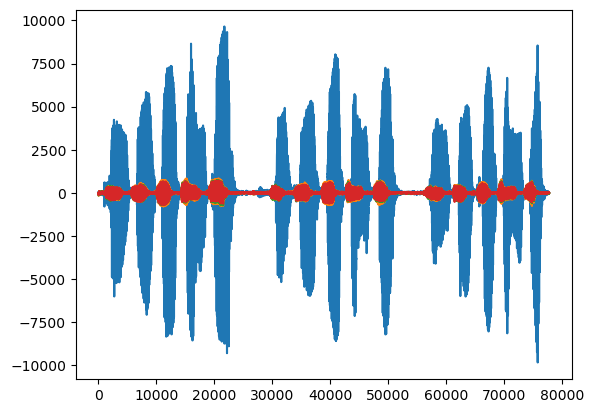

In [22]:
# 音をプロット
data = b''.join(frames) # バイナリデータを結合
data = np.frombuffer(data, dtype='int16') # int16に変換
data = data.reshape(-1, chans) # チャンネル数に合わせて整形 (n_samples, n_channels)
data_plot = data.T # 転置 (n_channels, n_samples)
for i in range(chans):
    # 色を塗りつぶさない
    plt.plot(data_plot[i])
plt.show()

In [24]:
import pyroomacoustics as pra
# DOA推定のための設定
c = 343.    # speed of sound
fs = 16000  # サンプリングレート
nfft = 256  # FFT size
freq_range = [300, 3500]
snr_db = 5.    # ガウスノイズのSNR
mic_num = 4

mic_locs = pra.circular_2D_array(center=[0,0], M=mic_num, phi0=0, radius=0.05)
X = pra.transform.stft.analysis(data, nfft, nfft // 2)
X = X.transpose([2, 1, 0])

print(data.shape)
print(X.shape)
# DOAの計算
doa = pra.doa.algorithms['MUSIC'](mic_locs, fs, nfft, c=c, num_src=1, max_four=4)
doa.locate_sources(X, freq_range=freq_range)
spatial_resp = doa.grid.values
min_val = spatial_resp.min()
max_val = spatial_resp.max()
spatial_resp = (spatial_resp - min_val) / (max_val - min_val)
# spatial_resp = (spatial_resp) / (max_val) # normalize to 0-1

(77824, 4)
(4, 129, 608)


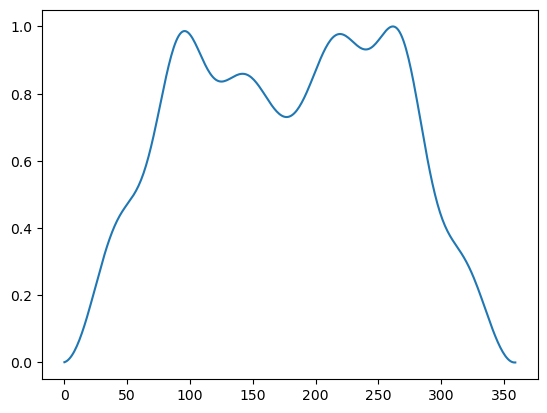

In [26]:
# spatial_respをプロット
plt.figure()
plt.plot(np.rad2deg(doa.grid.azimuth), spatial_resp.T)
plt.show()